In [27]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import warnings
import os 
import missingno as msno 
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE

import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [3]:
#set working drive
os.chdir("C:/Users/JHo/Desktop/Queens GMMA/GMMA 823 Analytics for Financial Mgmt/Assignment 2")
os.getcwd()

'C:\\Users\\JHo\\Desktop\\Queens GMMA\\GMMA 823 Analytics for Financial Mgmt\\Assignment 2'

In [5]:
#load dataset
bank = pd.read_excel('Bankruptcy_data_Final.xlsx')

In [7]:
bank.info()
bank.head()
bank.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92872 entries, 0 to 92871
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Data Year - Fiscal  92872 non-null  int64  
 1   Tobin's Q           92620 non-null  float64
 2   EPS                 92867 non-null  float64
 3   Liquidity           92625 non-null  float64
 4   Profitability       92625 non-null  float64
 5   Productivity        92625 non-null  float64
 6   Leverage Ratio      92846 non-null  float64
 7   Asset Turnover      92625 non-null  float64
 8   Operational Margin  87315 non-null  float64
 9   Return on Equity    92864 non-null  float64
 10  Market Book Ratio   92815 non-null  float64
 11  Assets Growth       86171 non-null  float64
 12  Sales Growth        86171 non-null  float64
 13  Employee Growth     85862 non-null  float64
 14  BK                  92872 non-null  int64  
dtypes: float64(13), int64(2)
memory usage: 10.6 MB


,Data Year - Fiscal,Tobin's Q,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK
0,1979,0.980,1.580,0.360,0.180,0.130,1.330,1.770,0.070,0.150,2.220,nan,nan,nan,0
1,1980,0.980,1.410,0.360,0.190,0.120,1.310,1.590,0.070,0.130,2.410,0.126,0.014,0.040,0
2,1981,0.870,0.310,0.320,0.130,0.080,1.030,1.550,0.050,0.040,2.560,0.368,0.328,0.567,0
3,1982,1.130,0.710,0.280,0.140,0.080,0.800,1.390,0.060,0.050,5.280,-0.021,-0.119,-0.096,0
4,1983,1.260,0.750,0.410,0.130,0.080,0.200,1.300,0.060,0.040,8.680,0.233,0.147,0.053,0


,Data Year - Fiscal,Tobin's Q,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK
count,92872.000,92620.000,92867.000,92625.000,92625.000,92625.000,92846.000,92625.000,87315.000,92864.000,92815.000,86171.000,86171.000,85862.000,92872.000
mean,2004.106,25.369,-14.461,-2.631,-29.537,-1.223,1.345,1.054,-7.915,-2.112,358.506,1.294,1.900,0.343,0.006
std,9.876,902.819,2195.467,121.611,677.231,35.886,253.038,2.116,214.460,352.597,26063.638,73.770,177.633,14.074,0.077
min,1979.000,0.009,-384000.000,-25968.520,-79682.000,-5093.000,-7811.000,-31.590,-30175.700,-88875.140,-3151500.000,-1.000,-27.431,-1.000,0.000
25%,1998.000,1.120,-0.140,0.020,-0.640,-0.060,0.000,0.390,-0.030,-0.080,11.200,-0.053,-0.034,-0.048,0.000
50%,2006.000,1.540,0.330,0.190,0.070,0.060,0.280,0.830,0.060,0.030,58.280,0.052,0.060,0.017,0.000
75%,2012.000,2.590,1.530,0.400,0.310,0.110,0.820,1.390,0.140,0.070,240.140,0.192,0.204,0.131,0.000
max,2017.000,194537.670,55339.000,1.000,140.580,1102.000,75970.380,276.380,394.470,39500.000,3455419.330,14231.000,39850.000,2699.000,1.000


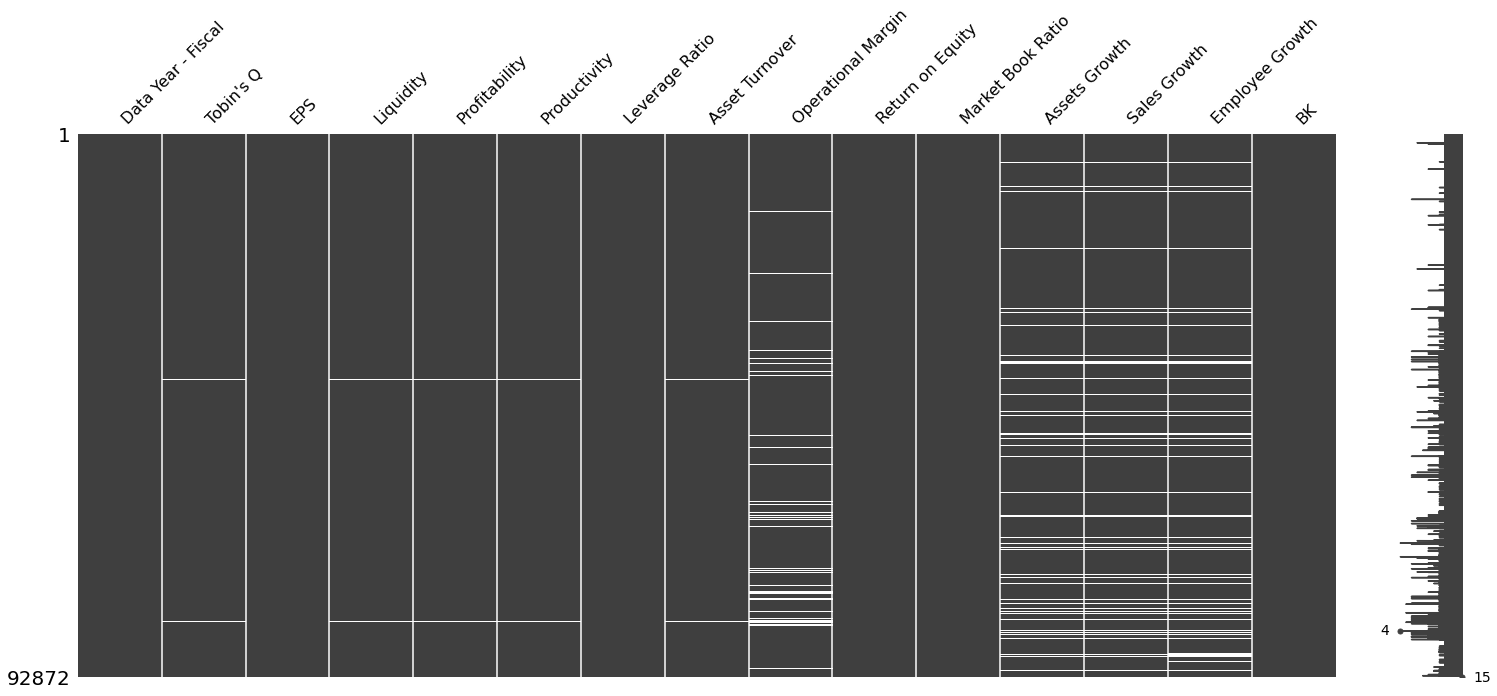

In [9]:
#missmap
msno.matrix(bank)

In [10]:
#subset without target var
bank_col = bank.iloc[:, 0:14]

In [12]:
# knn imputation for missing values (note: KNN performs better with non-categorical data)
from numpy import isnan
from pandas import read_csv
from sklearn.impute import KNNImputer

# split into input and output elements
data = bank.values
ix = [i for i in range(data.shape[1]) if i != 14]
X, y = data[:, ix], data[:, 14]
# print total missing
print('Missing: %d' % sum(isnan(X).flatten()))
# define imputer
imputer = KNNImputer()
# fit on the dataset
imputer.fit(X)
# transform the dataset
Xtrans = imputer.transform(X)
# print total missing
print('Missing: %d' % sum(isnan(Xtrans).flatten()))

Missing: 27305


KNNImputer()

Missing: 0


In [13]:
#fill subset with imputed values
bank_col[:]= imputer.transform(Xtrans)

In [14]:
#create feature for financial crisis flag
#source:https://www.reuters.com/article/us-financial-crises-history/factbox-financial-crises-in-last-40-years-idUSTRE4AD6D520081114
#source:https://www.ifre.com/story/1291951/a-history-of-the-past-40-years-in-financial-crises-0dxjlzsrcx

def crisis(x):
    if x in (1981,1986,1988,1990,1991,1992,1993,1994,1995,1996,1998,1999,2000,2001):
        return 1
    elif x in (1987,1989,1997):
        return 2
    else: return 0

bank_col['fin_crisis'] =  bank_col['Data Year - Fiscal'].apply(crisis)

In [15]:
#add back target variable
bank_col['BK'] = bank['BK']

In [16]:
#re-check
##bank_col.info()
##bank_col.head()
##bank_col.describe()

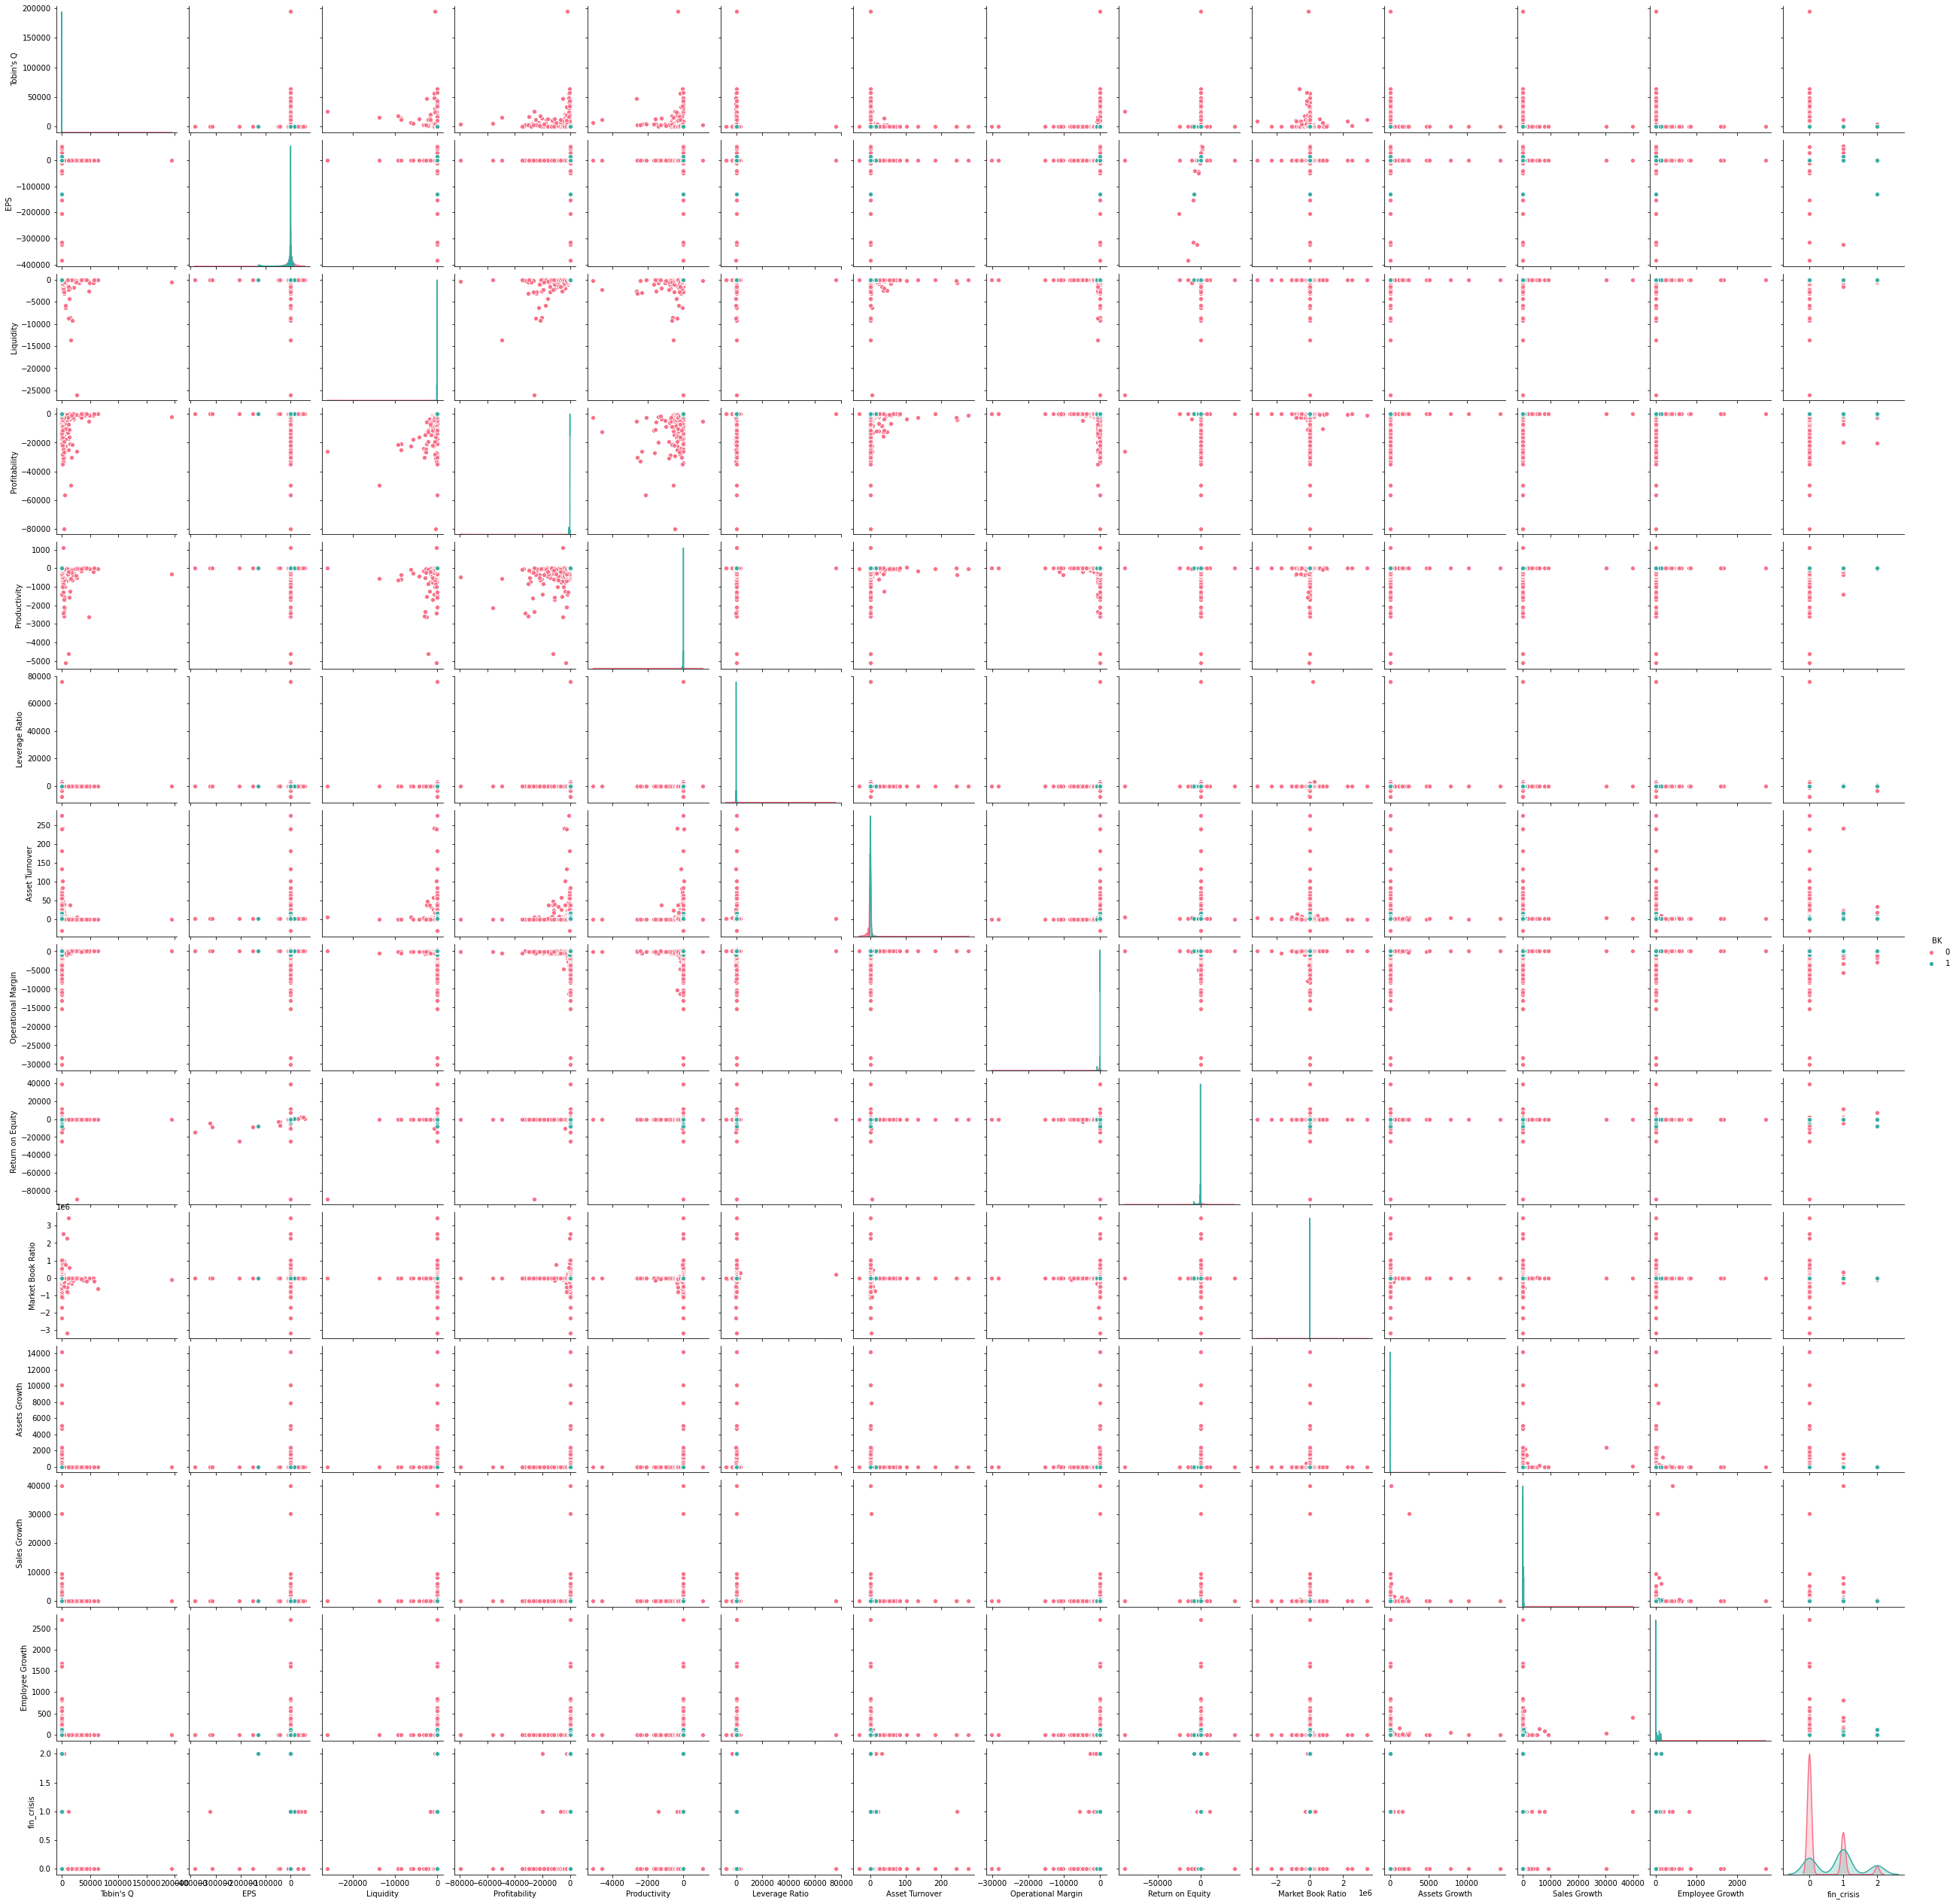

In [23]:
#check distributions and visual correlation
pp =sns.pairplot(bank_col.drop('Data Year - Fiscal',axis=1), hue = 'BK', palette='husl')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FFC15F80C8>,
      dtype=object)

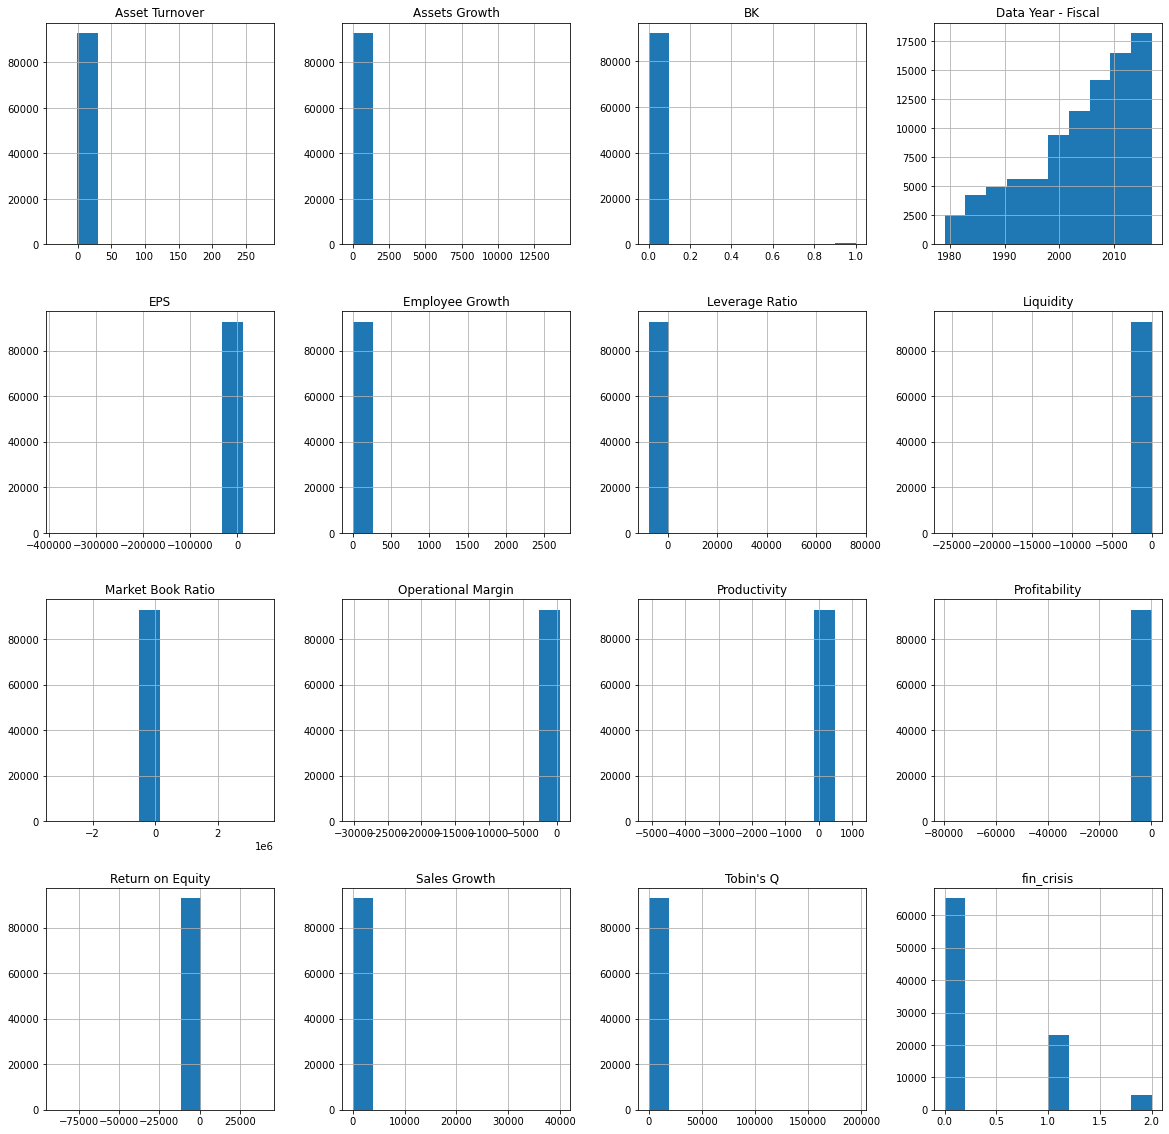

In [24]:
#check distribution
bank_col.hist(figsize = (20,20))

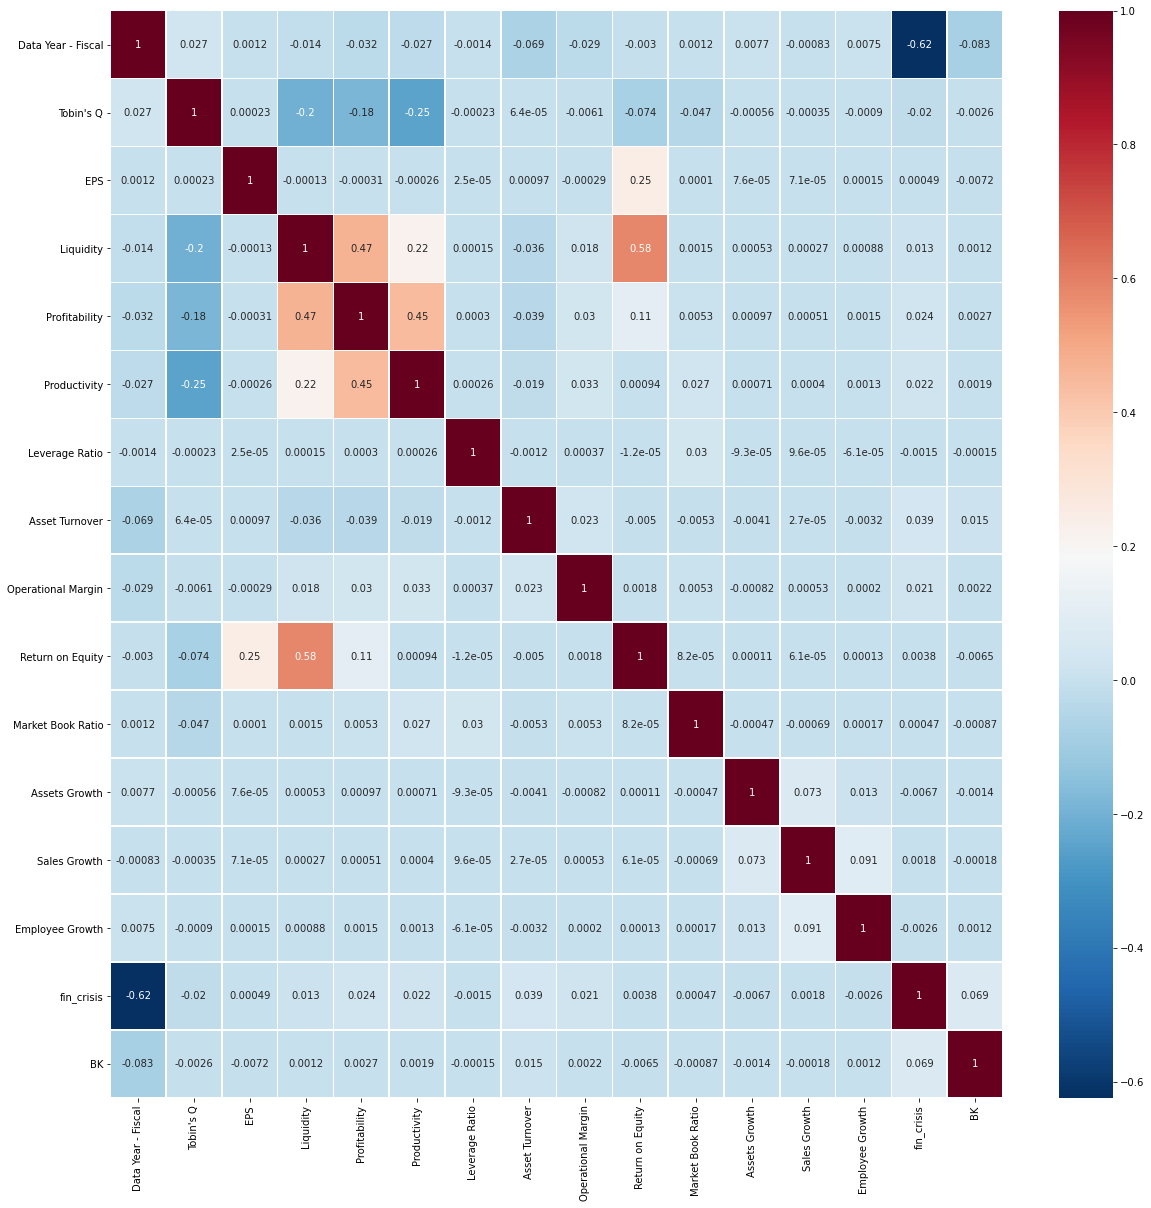

In [28]:
#check correlation of features
pearsoncorr = bank_col.corr(method='pearson') #pearson
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5,
            ax=ax)

In [ ]:
#drop date field (highly correlated to target variable but spurious correlation)
bank_col = bank_col.drop('Data Year - Fiscal', axis=1)
#bank_col.head()

In [31]:
#create working df without target variable
bank_fit = bank_col.copy()
bank_fit = bank_fit.drop('BK', axis=1)

#scale data
scaler = StandardScaler()
bank_fit = pd.DataFrame(StandardScaler().fit_transform(bank_fit), columns=bank_fit.columns, index=bank_fit.index)

#rejoin target
bank_fit['BK'] = bank_col['BK']

## Create Oversample Dataset to Balance Target Variable 

In [32]:
#view shape of variables and target
X = np.array(bank_fit.iloc[:, bank_fit.columns != 'BK'])
y = np.array(bank_fit.iloc[:, bank_fit.columns == 'BK'])
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (92872, 14)
Shape of y: (92872, 1)


In [33]:
#create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (65010, 14)
Number transactions y_train dataset:  (65010, 1)
Number transactions X_test dataset:  (27862, 14)
Number transactions y_test dataset:  (27862, 1)


In [34]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': [393]
Before OverSampling, counts of label '0': [64617] 

After OverSampling, the shape of train_X: (129234, 14)
After OverSampling, the shape of train_y: (129234,) 

After OverSampling, counts of label '1': 64617
After OverSampling, counts of label '0': 64617


## Modelling 

In [35]:
from sklearn.ensemble import RandomForestClassifier

clfs = [
    xgb.XGBClassifier(),
    lgb.LGBMClassifier(),
    RandomForestClassifier(),
    SVC(gamma="auto"), 
    MLPClassifier(),
    GaussianNB(),
#     GaussianProcessClassifier()
]
clf_names = [
    "XGBoost",
    "LightGBM",
    "RandomForestClassifier",
    "SVC",
    "NeuralNetwork",
    "NaiveBayes",
#     "Gaussian"
]

In [36]:
scores = np.zeros(len(clfs))

In [38]:
for i in np.arange(len(clfs)):
    print(clf_names[i])
    scores[i] = np.mean(cross_validate(clfs[i], X_train_res, y_train_res, scoring="roc_auc", cv=5, return_train_score=False)["test_score"])

XGBoost
LightGBM
RandomForestClassifier
SVC
NeuralNetwork


C:\Users\JHo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\JHo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\JHo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\JHo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceW

NaiveBayes


In [43]:
#X_train,y_train
pd.DataFrame(scores, index=clf_names, columns=["Score"])

,Score
XGBoost,0.998
LightGBM,0.995
RandomForestClassifier,1.000
SVC,0.838
NeuralNetwork,0.966
NaiveBayes,0.605


# Baseline Model

In [44]:
#run baseline on test dataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

clf = xgb.XGBClassifier()
clf.fit(X_train_res, y_train_res)
predict = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)
print ("AUC:",roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
print("Accuracy:",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

AUC: 0.9404464546537695
Accuracy: 0.9735482018519848
[[27033   664]
 [   73    92]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     27697
           1       0.12      0.56      0.20       165

    accuracy                           0.97     27862
   macro avg       0.56      0.77      0.59     27862
weighted avg       0.99      0.97      0.98     27862



# Best Model - Hyperparameter Tuned (see line 73 of code)

In [45]:
#Hyperparameter tuned model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

clf = xgb.XGBClassifier(
        objective = 'binary:logistic',
        colsample_bytree = 0.5,
        learning_rate = 0.1,
        max_depth = 7,
        min_child_weight = 5,
        n_estimators = 100,
        subsample = 0.7)

clf.fit(X_train_res, y_train_res)
predict = clf.predict_proba(X_test)[:, 1]
y_pred = clf.predict(X_test)
print ("AUC:",roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
print("Accuracy:",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

AUC: 0.9454945891744101
Accuracy: 0.9551719187423732
[[26495  1202]
 [   47   118]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     27697
           1       0.09      0.72      0.16       165

    accuracy                           0.96     27862
   macro avg       0.54      0.84      0.57     27862
weighted avg       0.99      0.96      0.97     27862



In [103]:
z = bank_col.drop('BK', axis=1)

In [42]:
#feature importance plot
from xgboost import plot_importance
from matplotlib import pyplot

# create dictionary for feature names (or they appear in index order f1,f2,...)
myfeatures = z.columns
dict_features = dict(enumerate(myfeatures))

# feat importance with names f1,f2,...
axsub = xgb.plot_importance(clf)

# rejoin feature names from dictionary
Text_yticklabels = list(axsub.get_yticklabels())
dict_features = dict(enumerate(myfeatures))
lst_yticklabels = [ Text_yticklabels[i].get_text().lstrip('f') for i in range(len(Text_yticklabels))]
lst_yticklabels = [ dict_features[int(i)] for i in lst_yticklabels]

axsub.set_yticklabels(lst_yticklabels)
print(dict_features)
plt.show()

NameError: name 'z' is not defined

In [82]:
#create confusion matrix plot
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the train dataset: 71.51515151515152%


<Figure size 432x288 with 0 Axes>

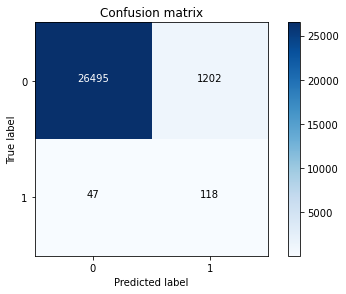

In [83]:
#confusion materix
y_pred = clf.predict(X_test)

cnf_matrix_tra = confusion_matrix(y_test, y_pred)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

<Figure size 432x288 with 0 Axes>

(-0.02, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC curve')

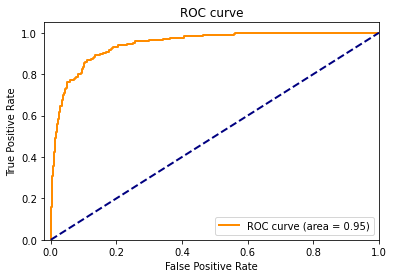

In [90]:
#ROC curve

from sklearn.metrics import roc_curve, auc

# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, predict)
roc_auc = auc(fpr, tpr)
#xgb.plot_importance(gbm)
#plt.show()
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
        lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()
 

# Hyperparameter tuning for XGBoost ( DO NOT RE-RUN, TAKES FOREVER)

In [73]:
from sklearn.model_selection import GridSearchCV

#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train_res, y_train_res):
    param_tuning = {
        'learning_rate': [0.01, 0.1, 0.3, 0.5],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['binary:logistic']
    }

    xgb_model = xgb.XGBClassifier()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [74]:
#most optimal parameters
hyperParameterTuning(X_train_res, y_train_res)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


C:\Users\JHo\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 5,
 'n_estimators': 100,
 'objective': 'reg:squarederror',
 'subsample': 0.7}